# Speaker Recognition with SpeechBrain ECAPA-TDNN
This notebook demonstrates...

## 1. Setup and Imports

In [3]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import speechbrain
import torchaudio
import sys
import os

### Fix torchaudio backend compatibility

In [4]:
if hasattr(torchaudio, 'list_audio_backends'):
    backends = torchaudio.list_audio_backends()
else:
    backends = ['torchcodec']

sys.modules['torchaudio'].list_audio_backends = lambda: backends

### Monkey-patch huggingface_hub for compatibility

In [5]:
import huggingface_hub

original_hf_hub_download = huggingface_hub.hf_hub_download

def patched_hf_hub_download(*args, **kwargs):
    if 'use_auth_token' in kwargs:
        kwargs['token'] = kwargs.pop('use_auth_token')
    return original_hf_hub_download(*args, **kwargs)

huggingface_hub.hf_hub_download = patched_hf_hub_download

## 2. Load Pre-trained ECAPA-TDNN Model

In [7]:
from speechbrain.inference import EncoderClassifier

print("Loading speechbrain ECAPA-TDNN model...")

classifier = EncoderClassifier.from_hparams(
    source="pretrained_models",
    savedir="pretrained_models"
)

print("✓ Model loaded successfully!")

Loading speechbrain ECAPA-TDNN model...


c:\Users\highe\anaconda3\envs\Data-prepocessing\Lib\site-packages\speechbrain\utils\autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
c:\Users\highe\anaconda3\envs\Data-prepocessing\Lib\site-packages\speechbrain\utils\parameter_transfer.py:234: UserWarning: Requested Pretrainer collection using symlinks on Windows. This might not work; see `LocalStrategy` documentation. Consider unsetting `collect_in` in Pretrainer to avoid symlinking altogether.
  warnings.warn(
c:\Users\highe\anaconda3\envs\Data-prepocessing\Lib\site-packages\speechbrain\utils\checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (S

✓ Model loaded successfully!


c:\Users\highe\anaconda3\envs\Data-prepocessing\Lib\site-packages\speechbrain\processing\features.py:1529: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stats = torch.load(p

## 3. Load Audio Dataset

In [ ]:
CSV_PATH = "audio_features.csv"
df = pd.read_csv(CSV_PATH)

print(f"Loaded {len(df)} audio samples")
print(df.head())

speaker_counts = df['member_name'].value_counts()
print(speaker_counts)

### Visualize Speaker Distribution

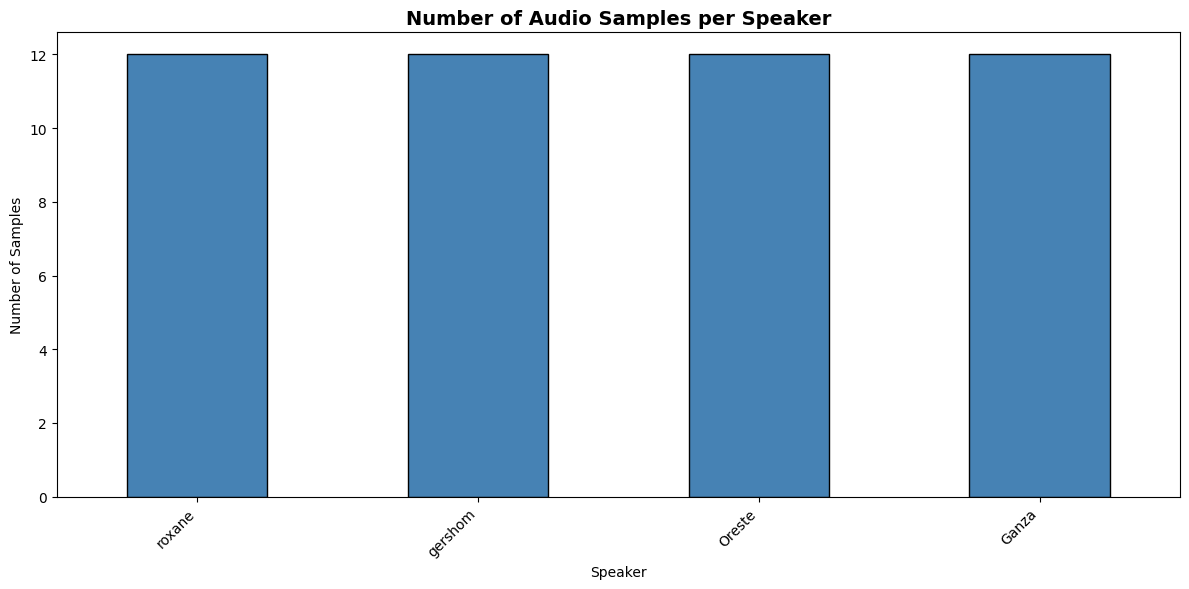

In [10]:
plt.figure(figsize=(12, 6))
speaker_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Number of Audio Samples per Speaker', fontsize=14, fontweight='bold')
plt.xlabel('Speaker')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Extract Speaker Embeddings

In [11]:
import os
import numpy

# Set audio path
AUDIO_BASE_PATH = r"C:\Users\highe\Data-prepocessing\Audios"

# Fix paths in dataframe
sample_path = df['audio_path'].iloc[0]
print(f"Original path from CSV: {sample_path}")

if not os.path.exists(sample_path):
    df['audio_path'] = df['audio_path'].apply(
        lambda x: os.path.join(AUDIO_BASE_PATH, os.path.basename(x))
    )
    print(f"✓ Adjusted paths")
    print(f"New path: {df['audio_path'].iloc[0]}")

# Test with first file
test_audio = df['audio_path'].iloc[0]
print(f"\nTesting with: {test_audio}")
print(f"File exists: {os.path.exists(test_audio)}")

if os.path.exists(test_audio):
    try:
        # Load with librosa
        y, sr = librosa.load(test_audio, sr=16000)
        print(f"✓ Loaded audio successfully")
        print(f"  Audio shape: {y.shape}")
        print(f"  Sample rate: {sr}")
        print(f"  Audio dtype: {y.dtype}")
        
        # Try conversion methods
        print("\nTesting tensor conversions:")
        
        # Method 1: from_numpy with contiguous float32
        try:
            y_clean = np.ascontiguousarray(y.astype(np.float32))
            waveform = torch.from_numpy(y_clean).unsqueeze(0)
            print(f"  ✓ Method works! Waveform shape: {waveform.shape}")
            
            # Test with model
            with torch.no_grad():
                emb = classifier.encode_batch(waveform)
            print(f"  ✓ Model inference works! Embedding shape: {emb.shape}")
            
        except Exception as e:
            print(f"  ✗ Failed: {e}")
            import traceback
            traceback.print_exc()
            
    except Exception as e:
        print(f"✗ Error loading audio: {e}")
else:
    print("✗ File not found! Check the path.")

Original path from CSV: Audios\roxane_yes_approve.wav

Testing with: Audios\roxane_yes_approve.wav
File exists: True
✓ Loaded audio successfully
  Audio shape: (56536,)
  Sample rate: 16000
  Audio dtype: float32

Testing tensor conversions:
  ✓ Method works! Waveform shape: torch.Size([1, 56536])
  ✓ Model inference works! Embedding shape: torch.Size([1, 1, 192])


In [12]:
def get_embedding(audio_path):
    """Extract ECAPA-TDNN embedding from audio file."""
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"File not found: {audio_path}")
    
    # Load audio at 16kHz
    y, sr = librosa.load(audio_path, sr=16000)
    
    # Convert to contiguous float32 numpy array, then to tensor
    y_clean = np.ascontiguousarray(y.astype(np.float32))
    waveform = torch.from_numpy(y_clean).unsqueeze(0)
    
    # Extract embedding
    with torch.no_grad():
        emb = classifier.encode_batch(waveform)
    
    return emb.squeeze().cpu().numpy()

# %%
embeddings = []
labels = []
failed_files = []

print("Extracting embeddings...")
print("-" * 50)

for idx, row in df.iterrows():
    if idx % 10 == 0:
        print(f"Progress: {idx}/{len(df)} ({idx/len(df)*100:.1f}%)")
    
    try:
        emb = get_embedding(row['audio_path'])
        embeddings.append(emb)
        labels.append(row['member_name'])
    except Exception as e:
        if len(failed_files) == 0:
            import traceback
            print(f"\n✗ FIRST ERROR - Full traceback:")
            print(traceback.format_exc())
            print("-" * 50)
        print(f"✗ Skipping {row['audio_path']}: {e}")
        failed_files.append(row['audio_path'])

print("-" * 50)
print(f"\n✓ Successfully extracted {len(embeddings)} embeddings from {len(df)} files")
if failed_files:
    print(f"✗ Failed to process {len(failed_files)} files")

if len(embeddings) == 0:
    raise ValueError("ERROR: No embeddings were extracted! Check your audio files.")


Extracting embeddings...
--------------------------------------------------
Progress: 0/48 (0.0%)
Progress: 10/48 (20.8%)
Progress: 20/48 (41.7%)
Progress: 30/48 (62.5%)
Progress: 40/48 (83.3%)
--------------------------------------------------

✓ Successfully extracted 48 embeddings from 48 files


In [15]:
X = np.array(embeddings)  # (N, 192)
y = np.array(labels)

## 5. Prepare Training and Validation Sets

In [16]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.3, stratify=y_enc, random_state=42
)

print(len(X_train), len(X_val))

33 15


## 6. Train Logistic Regression Classifier

In [17]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)
print("Training complete.")

Training complete.


## 7. Evaluate Model Performance

In [18]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

print("Train Acc:", accuracy_score(y_train, y_pred_train))
print("Val Acc:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

Train Acc: 1.0
Val Acc: 1.0
              precision    recall  f1-score   support

       Ganza       1.00      1.00      1.00         4
      Oreste       1.00      1.00      1.00         3
     gershom       1.00      1.00      1.00         4
      roxane       1.00      1.00      1.00         4

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



### Confusion Matrix

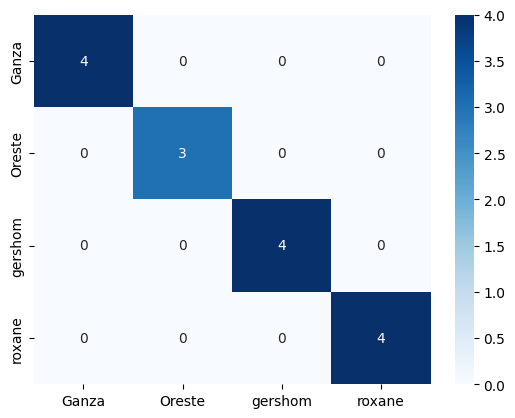

In [19]:
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

### Per-Class Metrics

In [20]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred_val)

metrics_df = pd.DataFrame({
    "Speaker": le.classes_,
    "Precision": precision,
    "Recall": recall,
    "F1": f1
})
metrics_df

,Speaker,Precision,Recall,F1
0,Ganza,1.0,1.0,1.0
1,Oreste,1.0,1.0,1.0
2,gershom,1.0,1.0,1.0
3,roxane,1.0,1.0,1.0


## 8. Save Model

In [ ]:
joblib.dump(model, "speechbrain_classifier.pkl")
joblib.dump(le, "speechbrain_label_encoder.pkl")
print("Models saved.")